# 00 Quickstart: DINOv3 Features

This notebook demonstrates how to load the DINOv3 backbone and visualize features using PCA.

2025-12-14 16:31:40.253558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765729900.273270    9589 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765729900.279359    9589 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-14 16:31:40.298483: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
`torch_dtype` is deprecated! Use `dtype` instead!
[W1214 16:31:44.322419914 NNPACK.cpp:61] Could not initialize NNPACK! Reaso

CLS shape: torch.Size([1, 1024])
Patch tokens shape: torch.Size([1, 196, 1024])


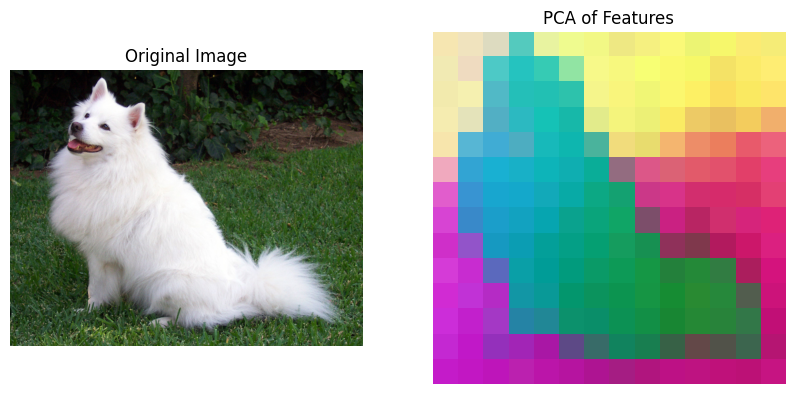

In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from transformers import AutoImageProcessor
from sklearn.decomposition import PCA

from dinov3_lab.core.backbone import build_dinov3_hf

# 1. Load Model
model_id = "facebook/dinov3-vitl16-pretrain-lvd1689m"
backbone = build_dinov3_hf(model_id=model_id)
processor = AutoImageProcessor.from_pretrained(model_id)

# 2. Load Image
# Replace with your image path
image_path = "../data/test_images/demo.jpg" 
# !wget https://github.com/pytorch/hub/raw/master/images/dog.jpg -O ../data/test_images/demo.jpg
try:
    image = Image.open(image_path).convert("RGB")
except FileNotFoundError:
    print("Please download a demo image to ../data/test_images/demo.jpg")
    # Create a dummy image
    image = Image.new('RGB', (448, 448), color = 'red')

inputs = processor(images=image, return_tensors="pt")

# 3. Extract Features
with torch.no_grad():
    out = backbone(inputs.pixel_values)

print(f"CLS shape: {out.cls.shape}")
print(f"Patch tokens shape: {out.patch_tokens.shape}")

# 4. Visualize PCA
patch_tokens = out.patch_tokens[0].float().cpu().numpy()
pca = PCA(n_components=3)
pca_features = pca.fit_transform(patch_tokens)

h, w = out.patch_hw
pca_img = pca_features.reshape(h, w, 3)

# Normalize to 0-1 for display
pca_img = (pca_img - pca_img.min()) / (pca_img.max() - pca_img.min())

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pca_img)
plt.title("PCA of Features")
plt.axis("off")
plt.show()